In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np


/home/x1b3d3ad/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,group_id
0,708479,256,1941550,14524320,1.96,18.9,0.0,13.52459,0


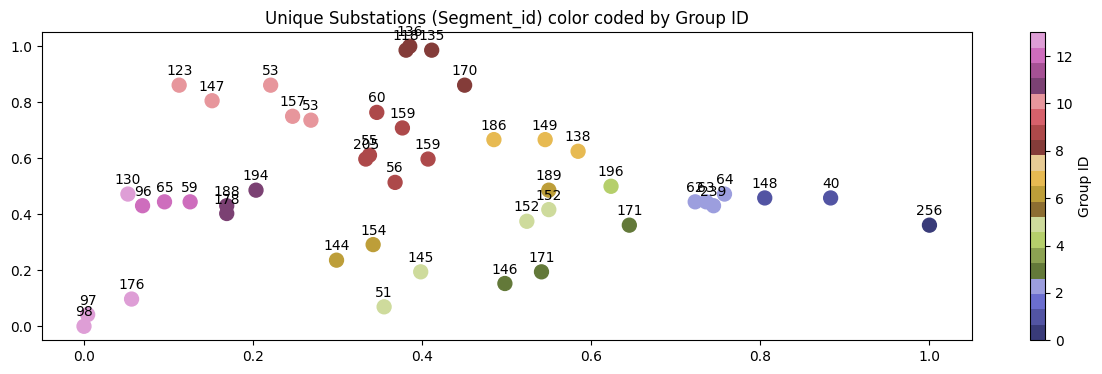

In [3]:
"""
Group stations based on geographic location according to the map in the document 
Grouping is found in the file Segment_group_id.csv
"""

df = pd.read_csv('data/RRCA_baseflow.csv')
group_ids = pd.read_csv('data/Segment_group_id.csv')
df = df.merge(group_ids, on='Segment_id', how="right")
display(df.head(1))
df.to_csv('data/RRCA_baseflow_grouped.csv', index=False)

df = df[['group_id', 'Segment_id', 'x', 'y']].drop_duplicates().reset_index(drop=True)
df['x'] = MinMaxScaler().fit_transform(df[['x']])
df['y'] = MinMaxScaler().fit_transform(df[['y']])
# display(df.head(1))

group_num = df['group_id']
y_text_offset = -0.05

plt.figure(figsize=(15, 4))
plt.title('Unique Substations (Segment_id) color coded by Group ID')
plt.scatter(df['x'], df['y'], c=group_num, cmap='tab20b', s=100)
for i, txt in enumerate(df['Segment_id']):
    plt.text(df.at[i, 'x'], df.at[i, 'y']-y_text_offset, str(txt), fontsize=10, color='black', ha='center', va='center')

plt.colorbar(label='Group ID')
plt.show()



In [4]:
from sklearn.preprocessing import PolynomialFeatures
""" 
    Preprocess the data
    - clean the date column to workable format
    - standardize the features and observed baseflow
    - 
"""
df = pd.read_csv('data/RRCA_baseflow_grouped.csv')
features = ['Evapotranspiration', 'Precipitation', 'Irrigation_pumping']
target = ['Observed']

# Convert the weird date (number of days) to a datetime object. We only care about the month
df['Date'] = df['Date'].apply(lambda x: x-693963)
df['Date'] = pd.to_datetime(df['Date'], unit='D', origin='1900-01-01')
# df = df[df['Date'] > '1960-01-01']
df.sort_values(by='Date', inplace=True)
df['Date'] = df['Date'].dt.to_period('M')
df['Date'] = df['Date'].dt.to_timestamp()

# Take only group 13 for testing. Average the stations for each month
# df = df[df['group_id'] == 13]
df = df.groupby(['group_id', 'Date']).mean().reset_index()

# Remove the end of river groups with no observed baseflow
no_record_groups = [0, 1, 4]
df = df[~df['group_id'].isin(no_record_groups)]
df = df.drop(columns=['Segment_id', 'x', 'y'])

def fillMissingDates(df):
    # # Fill in missing months with the average value of the previous and next month
    min_date = df['Date'].min()
    max_date = df['Date'].max()
    all_months = pd.period_range(start=min_date, end=max_date, freq='M')
    all_months = pd.DataFrame(all_months, columns=['Date'])
    merged = pd.merge(all_months, df, on='Date', how='right')
    merged = merged.fillna(method='ffill')
    return merged


for group in df['group_id'].unique():
    print(group)
    df_g = df[df['group_id'] == group]

    # Standardize the data
    scaler = StandardScaler()
    # df_g[features + target] = scaler.fit_transform(df_g[features + target])
    df_g.loc[:, features + target] = scaler.fit_transform(df_g.loc[:, features + target])

    # Remove outliers 
    df_g = df_g[(np.abs(df_g[features + target]) < 3).all(axis=1)]

    df_g = fillMissingDates(df_g)

    # Calculate the average baseflow for each month
    df_g['Month'] = df_g['Date'].dt.month
    monthly_avg = df_g.groupby(['Month'])[target].mean().reset_index()
    monthly_avg.columns = ['Month', 'AvgBaseflow']
    df_g = df_g.merge(monthly_avg, on=['Month'])


    # calculate water, precipitation minus evapotranspiration
    df_g['Water'] = df_g['Precipitation'] - df_g['Evapotranspiration'] - df_g['Irrigation_pumping']
    monthly_avg = df_g.groupby(['Month'])[['Water']].mean().reset_index()
    monthly_avg.columns = ['Month', 'AvgWater']
    df_g = df_g.merge(monthly_avg, on=['Month'])

    # Sort by date
    df_g.sort_values(by='Date', inplace=True)

    # display(df_g.head(5))

    df_g.to_csv(f'processedData/group_{group}.csv', index=False)

2
3
5
6
7
8
9
10
11
12
13


In [5]:
from sklearn.linear_model import LinearRegression
import os
""" For each month in the group, calculate the relationship between """

groups = os.listdir('processedData')
for group in groups:
    total_r2 = 0
    df = pd.read_csv(f'processedData/{group}')
    for month in df['Month'].unique():
        model = LinearRegression()
        df_m = df[df['Month'] == month]
        X = df_m[['Water']]
        y = df_m['Observed']
        model.fit(X, y)
        y_pred = model.predict(X)
        total_r2 += model.score(X, y)

    print(f'{group}: {total_r2/12}')

print(f'Total R2: {total_r2/len(groups)}')

group_5.csv: 0.059200179013135956
group_8.csv: 0.02094195455697853
group_10.csv: 0.0840987331842868
group_12.csv: 0.0884829225420456
group_2.csv: 0.027029768586024034
group_9.csv: 0.09969591009801564
group_4.csv: 0.0
group_7.csv: 0.020440611933135372
group_1.csv: 0.05998780590404045
group_13.csv: 0.3528682060865555
group_6.csv: 0.2085071856009848
group_3.csv: 0.03894510693198958
group_0.csv: 0.418650174472996
group_11.csv: 0.0399791346275565
Total R2: 0.03426782968076271


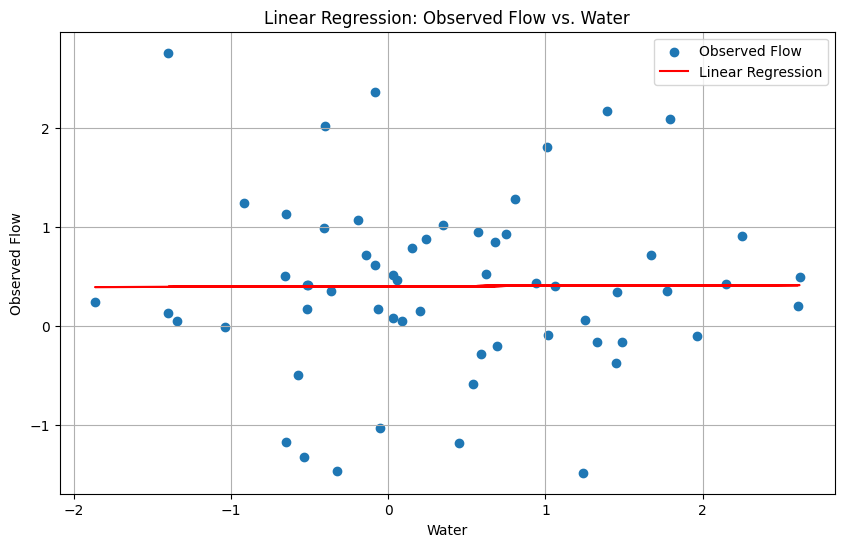

R-squared: 0.0000


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


df = pd.read_csv('processedData/group_11.csv')
df = df[df['Month'] == 1]

# Plot observed vs water on a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Water'], df['Observed'], label='Observed Flow')

# Fit linear regression model
model = LinearRegression()
X = df[['Water']]
y = df['Observed']
model.fit(X, y)

# Predict values using the model
y_pred = model.predict(X)

# Plot the regression line
plt.plot(X, y_pred, color='red', label='Linear Regression')

plt.xlabel('Water')
plt.ylabel('Observed Flow')
plt.title('Linear Regression: Observed Flow vs. Water')
plt.legend()
plt.grid(True)
plt.show()

# Calculate R-squared value
r2 = r2_score(y, y_pred)
print(f'R-squared: {r2:.4f}')


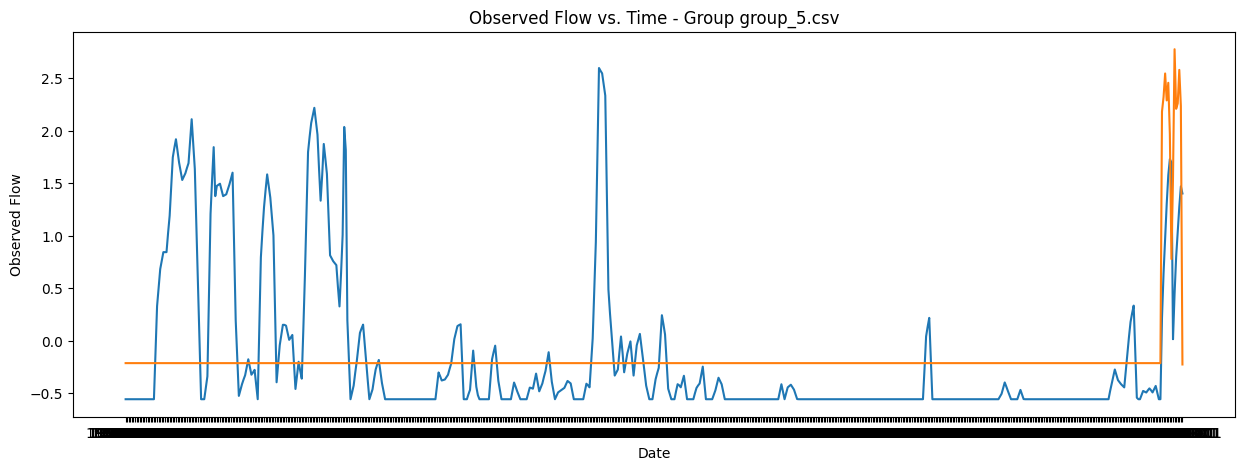

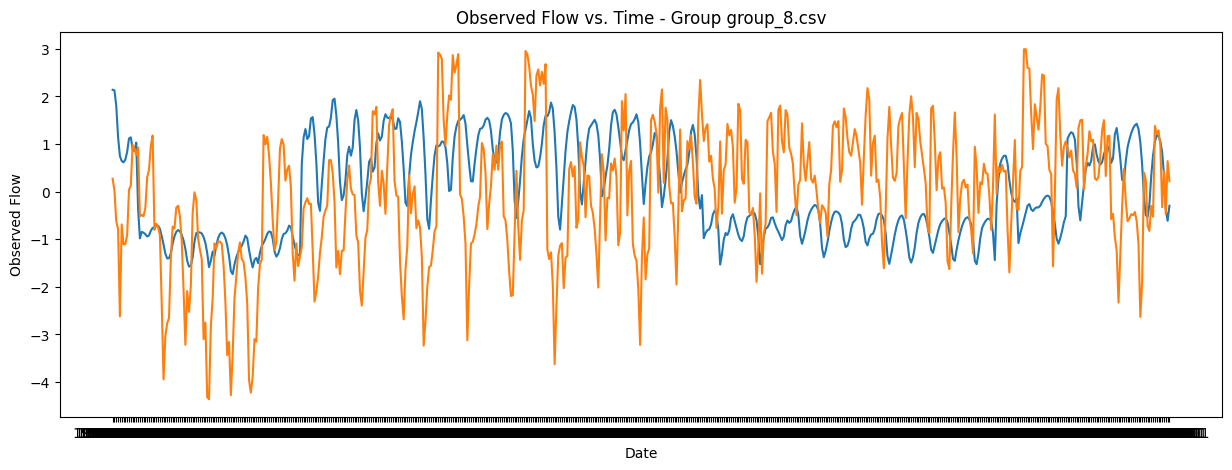

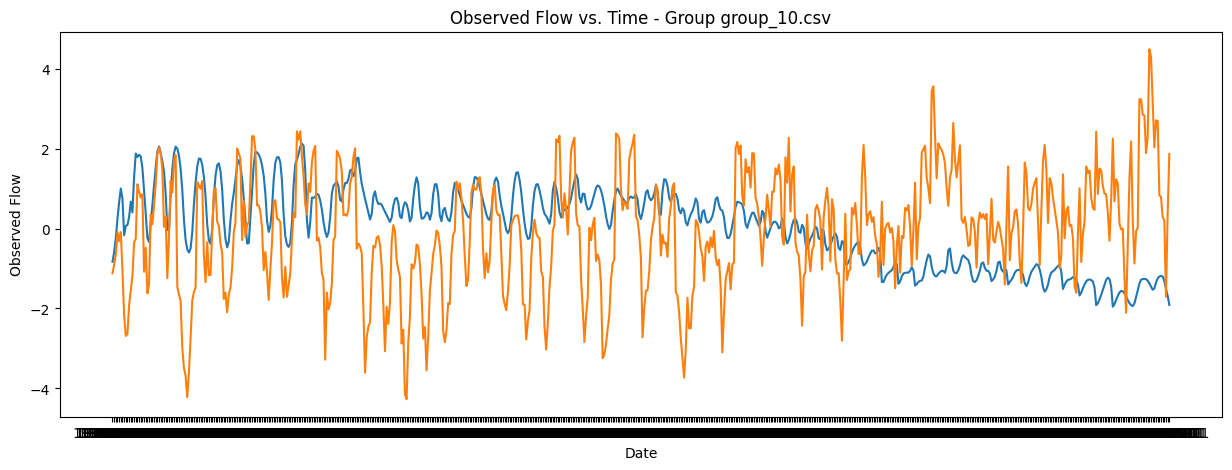

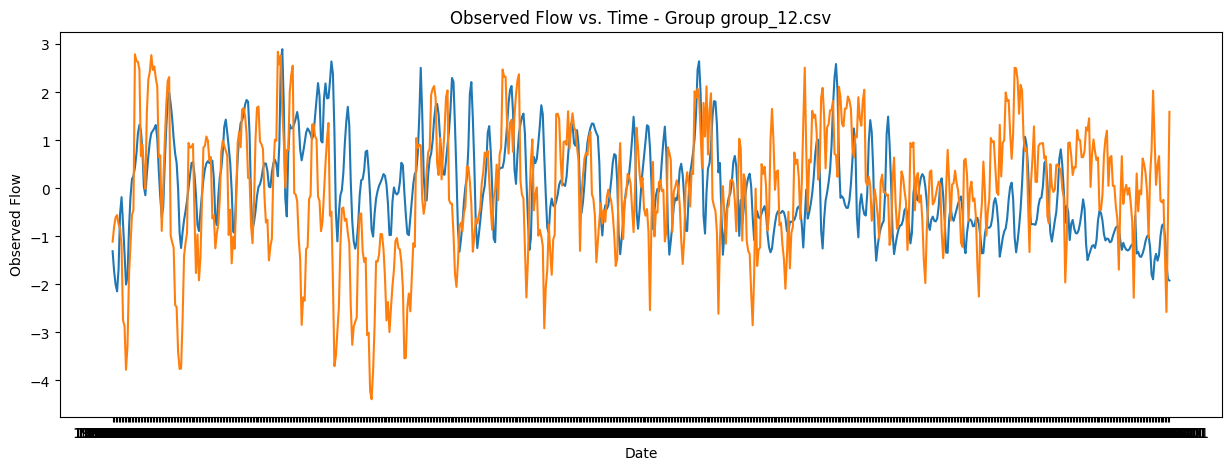

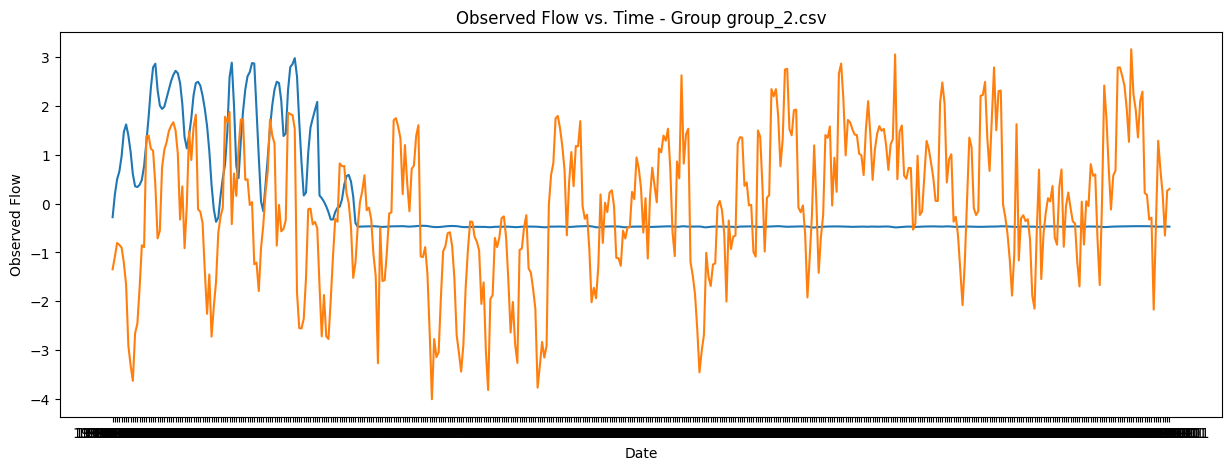

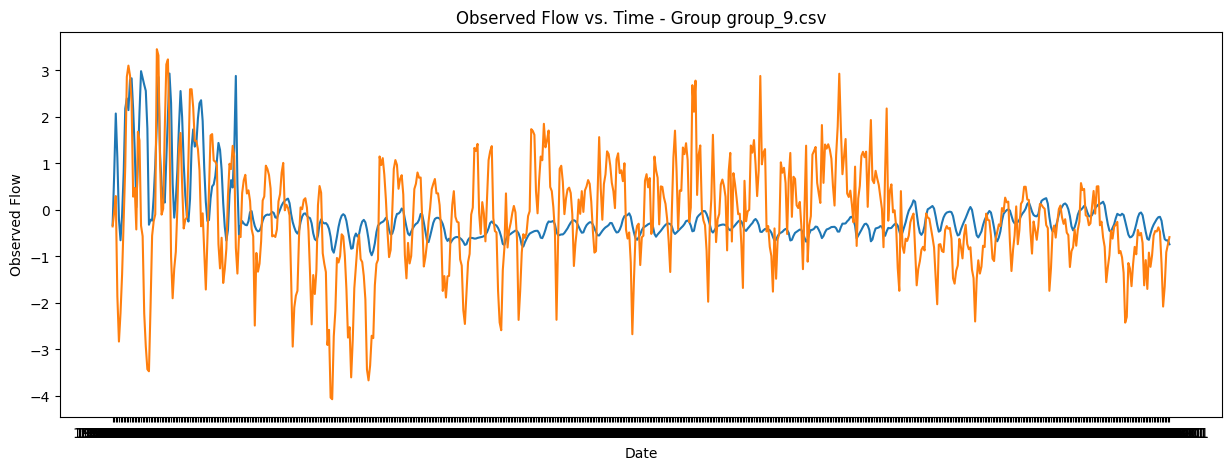

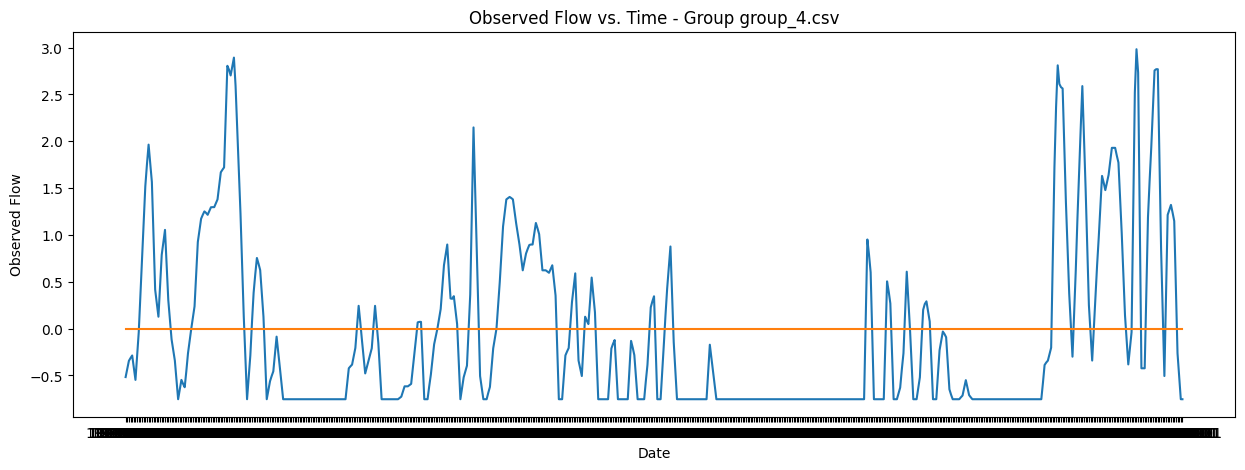

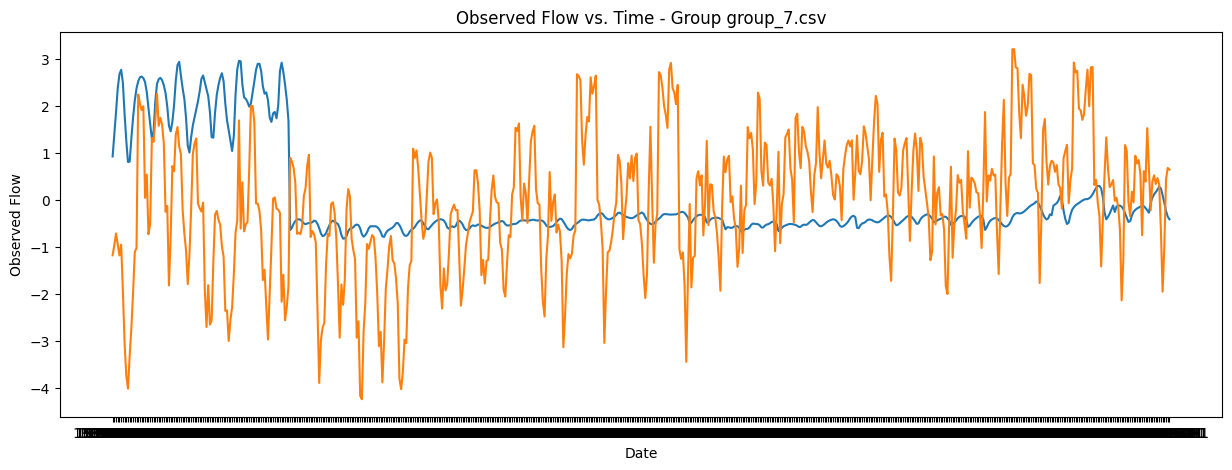

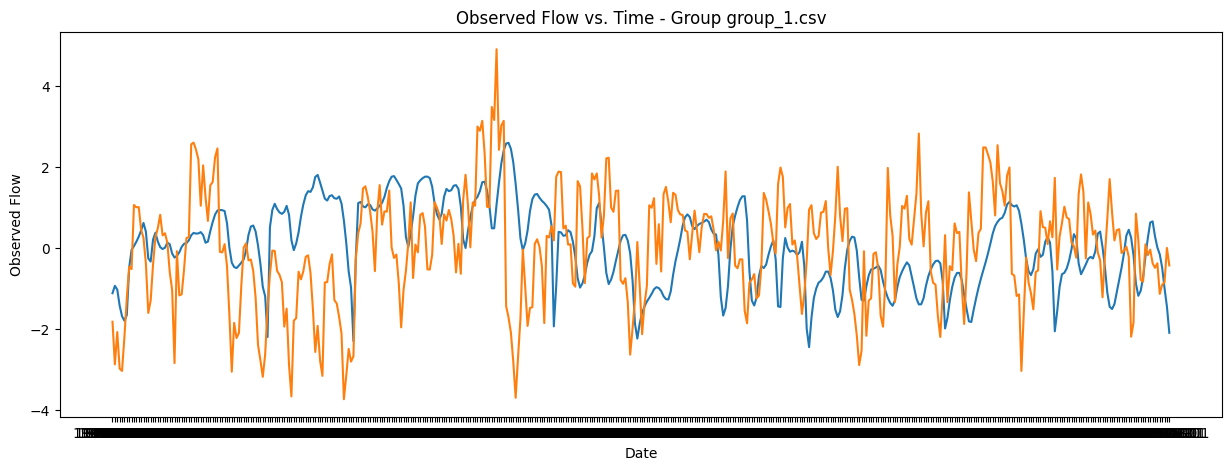

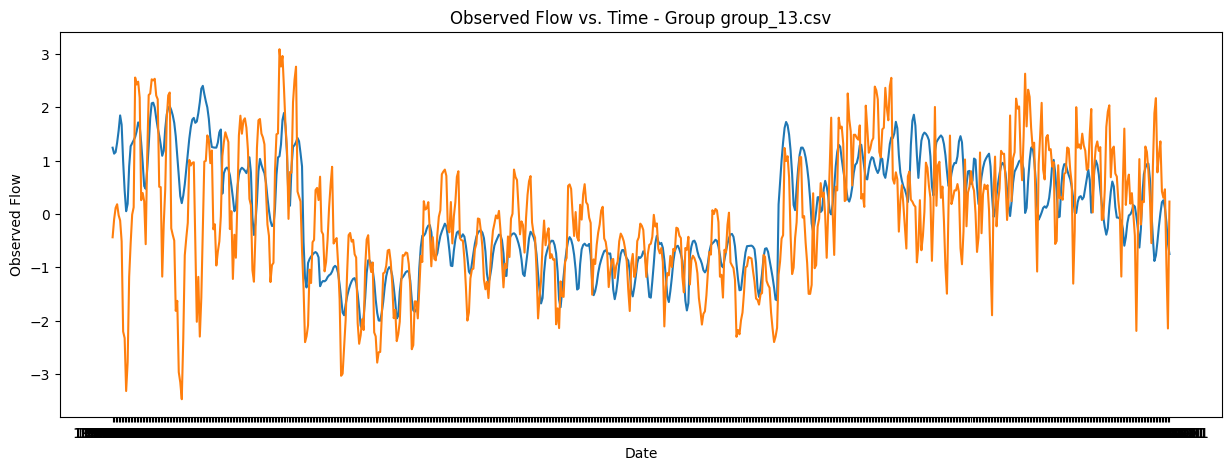

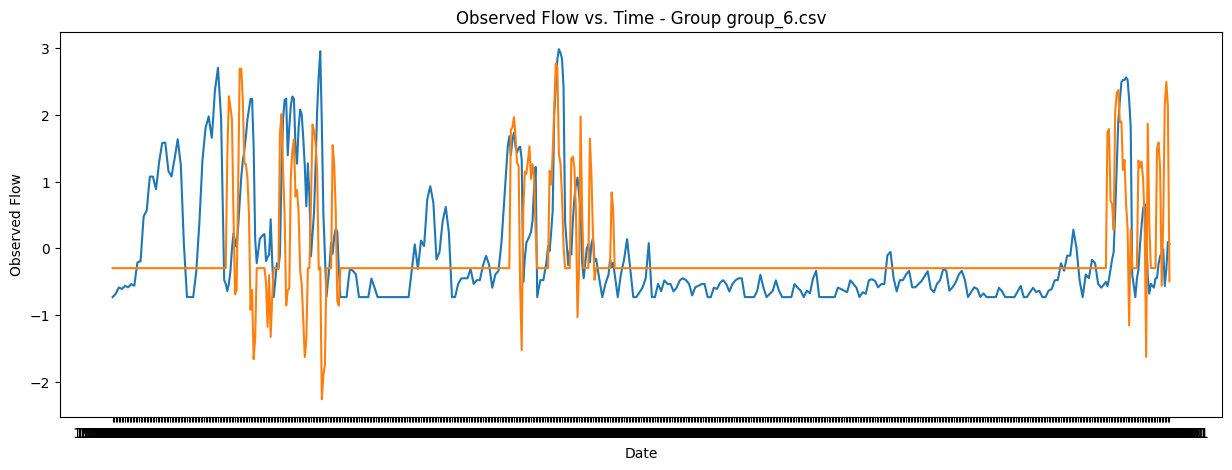

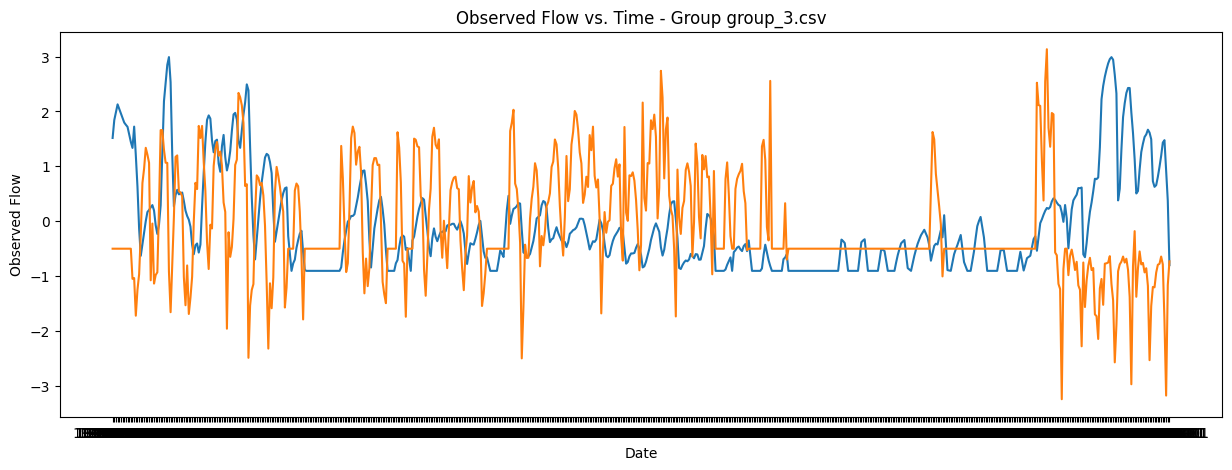

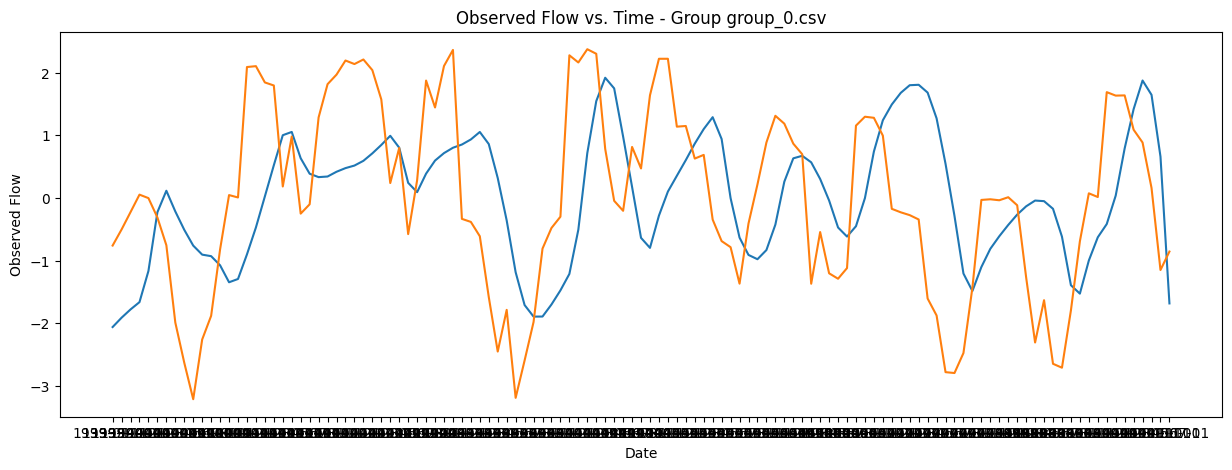

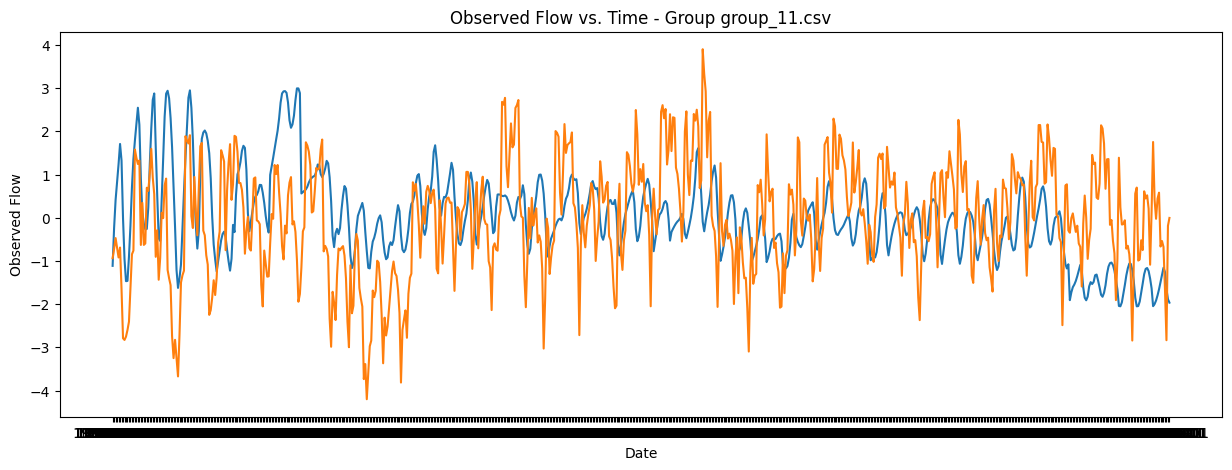

In [13]:
""" for each group in processedData, graph the observed vs time vs water
    Each group will have a separate graph"""
groups = os.listdir('processedData')
for group in groups:
    df = pd.read_csv(f'processedData/{group}')
    
    # Create a new figure for each group
    plt.figure(figsize=(15, 5))
    plt.plot(df['Date'], df['Observed'])
    plt.plot(df['Date'], df['Water'])
    plt.xlabel('Date')
    plt.ylabel('Observed Flow')
    plt.title(f'Observed Flow vs. Time - Group {group}')
    plt.show()  # Display the plot for this group